## Chapter 2-3, 1강 시계열 데이터 이해 및 분석 — Bike Sharing (Hourly)

- **목표**: 시계열 데이터의 기본 특성을 이해하고, 전처리·시각화·정상성·계절성·주기성·이상치·보간·간단 예측까지 실습합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn 사용 X), 색상 지정 X, 서브플롯 X

#### 구성
- 데이터 로딩과 점검: 시간 간격/누락/중복
- 집계와 시각화: 시간→일/주 변환, 캘린더 히트맵, 범주별 박스플롯
- 영향 요인 탐색: 근무일/주말/공휴일, 날씨 변수와 비선형(LOWESS)
- 정상성/계절성 분석: 이동통계, ADF, ACF/PACF, STL


> 이 노트북은 학습 목적의 EDA 흐름을 단계별로 보여주며, 각 코드 블록 앞뒤에 상세 설명을 제공합니다.


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- 통계적 정상성/계절성 분석을 위해 `statsmodels` 모듈을 사용합니다.
- 재현성과 간단한 수치 처리를 위해 `numpy`, `pandas`를 사용합니다.


In [2]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

# 전역 경고 억제 (미래/폐기 예정 경고 및 폰트 경고 노이즈 제거)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

# 노트북 전체 표시 옵션
pd.set_option('display.max_columns', 50)



#### 안내: 경고 억제와 한글 폰트
- 본 노트북은 시연의 가독성을 위해 Future/Deprecation 경고를 숨겼습니다.
- macOS/Windows/Noto 계열 폰트를 순차 탐색하여 한글이 깨지지 않도록 설정했습니다.


### 1. 데이터 불러오기와 기본 전처리

- `train.csv` 파일을 현재 디렉토리 또는 `./data/train.csv`, `/mnt/data/train.csv` 위치에서 탐색하여 읽습니다.
- `datetime`을 시계열로 파싱하고 정렬합니다.
- 강의에 필요한 열 순서를 고정합니다.


In [27]:
def load_data():
    """
    Bike Sharing Demand 학습용 데이터(`train.csv`)를 다음 경로에서 로드합니다.
    - 이 강의 저장소 구조: 'bike-sharing-demand/train.csv'

    반환 값:
        pandas.DataFrame: datetime 파싱과 열 정렬을 마친 데이터프레임
    """
    candidates = [
        'bike-sharing-demand/train.csv'
    ]
    path = None
    for c in candidates:
        if os.path.exists(c):
            path = c
            break
    if path is None:
        raise FileNotFoundError(
            "train.csv 경로를 찾을 수 없습니다."
        )

    df = pd.read_csv(path)
    # 1) 타입 처리: datetime 컬럼을 시계열로 파싱
    df['datetime'] = pd.to_datetime(df['datetime'])
    # 2) 시간 정렬 및 인덱스 초기화
    df = df.sort_values('datetime').reset_index(drop=True)
    # 3) 강의에 필요한 열 순서 고정
    cols = [
        'datetime','season','holiday','workingday','weather',
        'temp','atemp','humidity','windspeed','casual','registered','count'
    ]
    df = df[cols]
    return df

# 로드 및 기본 정보 출력
df = load_data()
print("데이터 크기:", df.shape)
print("기간:", df['datetime'].min(), "→", df['datetime'].max())
print(df.head(3))


데이터 크기: (10886, 12)
기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00
             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  


#### 왜 이 단계가 필요한가?
- **시계열 분석의 출발점**은 시간 열(`datetime`)이 올바른 타입과 순서로 정리되는 것입니다.
- Kaggle 원본 컬럼 구성 상, 분석에 쓰지 않는 컬럼은 없지만 강의에서는 학습 흐름을 위해 열 순서를 고정합니다.
- 출력으로 데이터 크기/기간/앞부분을 확인해 전체 범위와 시간 해상도를 감 잡습니다.


### 2. 시간 간격/결측/중복 체크

- 중복된 시각이 있는지 확인합니다.
- 실제 데이터의 간격 분포를 확인해 대표적 간격(top3)을 출력합니다.
- 기준 주기(여기서는 hourly)를 가정해 누락된 타임스탬프 개수를 계산합니다.

> 이 단계는 이후 보간·리샘플링 및 모델링 가정(정규 간격)에 대해 점검하는 역할을 합니다.


In [4]:
def check_time_gaps(data: pd.DataFrame) -> None:
    """
    시계열 품질 점검: 중복, 간격 빈도, 누락 개수 출력
    Args:
        data: 'datetime' 컬럼을 포함한 원본 DataFrame
    """
    # 1) 중복 개수
    dup = data['datetime'].duplicated().sum()
    print("중복 datetime 개수:", dup)

    # 2) 시간 간격 빈도 상위
    diffs = data['datetime'].diff().dropna()
    print("가장 흔한 간격(top 3):")
    print(diffs.value_counts().head(3))

    # 3) 누락된 타임스탬프 개수 (정규 hourly 가정)
    full = pd.date_range(start=data['datetime'].min(), end=data['datetime'].max(), freq='h')
    missing = np.setdiff1d(full.values, data['datetime'].values)
    print("누락된 시간 개수:", len(missing))

check_time_gaps(df)


중복 datetime 개수: 0
가장 흔한 간격(top 3):
datetime
0 days 01:00:00     10820
0 days 02:00:00        36
12 days 01:00:00       13
Name: count, dtype: int64
누락된 시간 개수: 6370


### 3. 인덱스 설정 및 리샘플링(시간→일/주)

- `datetime`을 인덱스로 설정하면 시계열 연산이 간단해집니다.
- 시간단위 수요(`count`)를 일/주 단위 평균으로 변환하여 큰 흐름(추세, 계절)을 확인합니다.

> 리샘플링은 추후 정상성 검사, 계절성 분석(STL/ACF) 등과 연결됩니다.


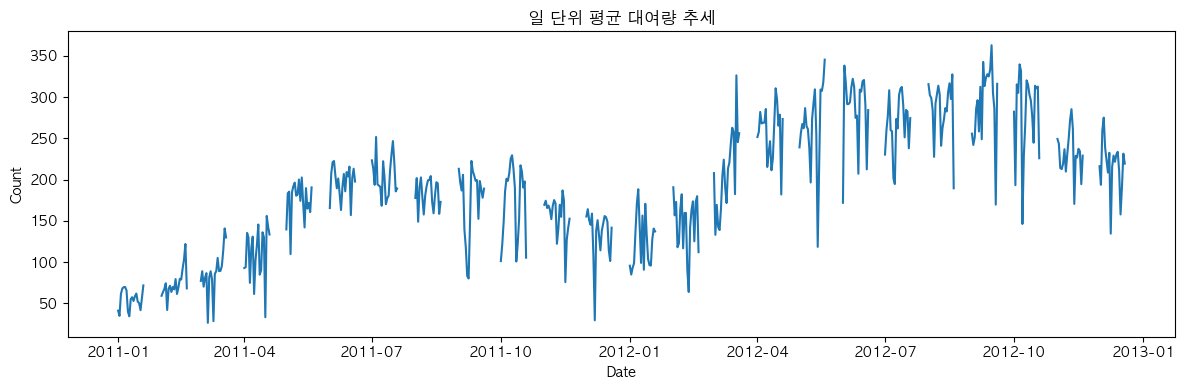

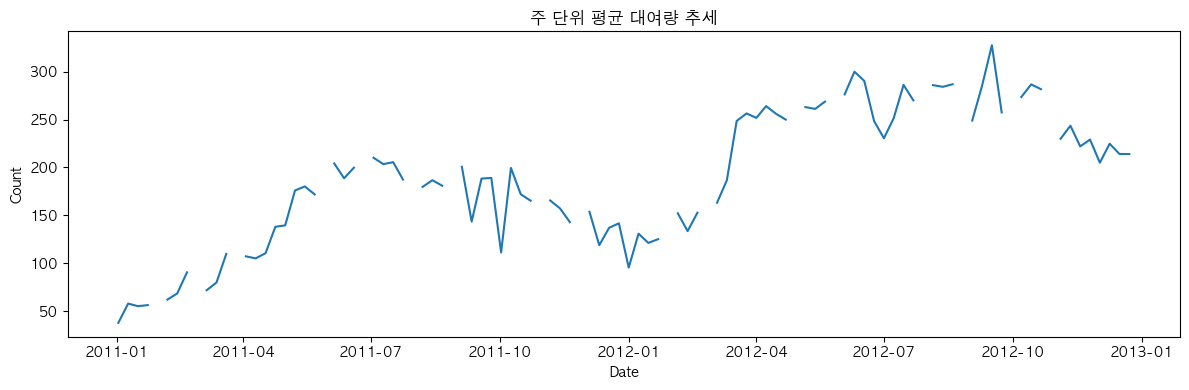

In [28]:
# 시계열 인덱스 설정
_df = df.set_index('datetime')

# 집계 및 시각화 함수
def resample_and_plot(series: pd.Series, rule: str, title: str) -> pd.Series:
    """
    시리즈를 주어진 규칙으로 집계(mean)하고 단일 선 그래프로 시각화합니다.
    Args:
        series: 시계열 Series (DatetimeIndex)
        rule: 리샘플 규칙('D','W' 등)
        title: 플롯 제목
    Returns:
        pd.Series: 리샘플된 평균 시리즈
    """
    agg = series.resample(rule).mean()
    plt.figure(figsize=(12,4))
    plt.plot(agg.index, agg.values)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    return agg

hourly = _df['count']
daily = resample_and_plot(hourly, 'D', '일 단위 평균 대여량 추세')
weekly = resample_and_plot(hourly, 'W', '주 단위 평균 대여량 추세')


#### 해설: 인덱스 설정 및 리샘플링(일/주)
- 목적: 시간 해상도를 낮춰 큰 흐름을 파악하고 변동성/계절성 확인.
- 해석 체크포인트:
  - 일 평균: 주기적 파형(주간/연간)이 시각적으로 드러납니다.
  - 주 평균: 장기 추세와 계절 요인 분리가 더 쉬워집니다.
  - 급격한 봉우리/골은 이벤트/기상 요인 가능성이 큽니다.


### 4. 달력(Weekday × Week) 히트맵

- 월별로 주차(week-of-month) × 요일(weekday) 그리드를 만들어, 일 평균 대여량의 달력 패턴을 직관적으로 확인합니다.
- 색상 지정 없이 기본 `imshow`를 사용합니다.

> 해석 팁: 특정 월/요일 조합에서 평균 수요가 상대적으로 높거나 낮은 구간이 보이면, 업무일/주말/휴일 효과와도 연계해볼 수 있습니다.


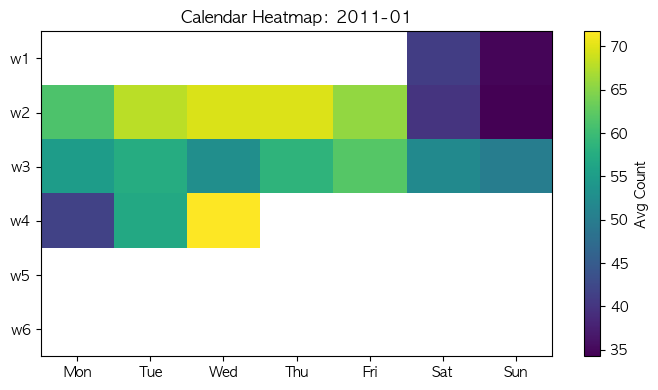

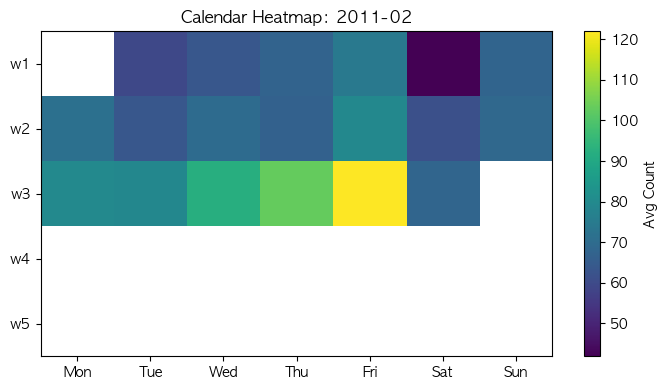

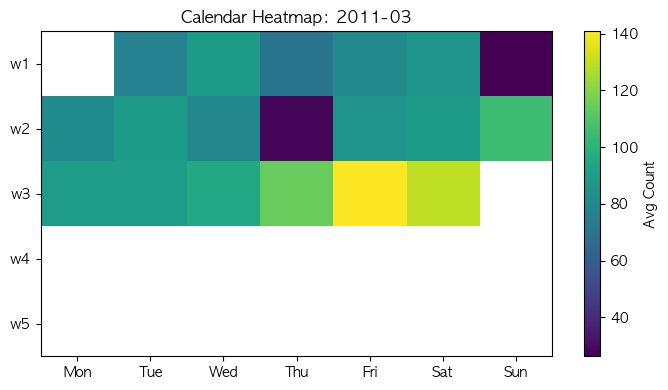

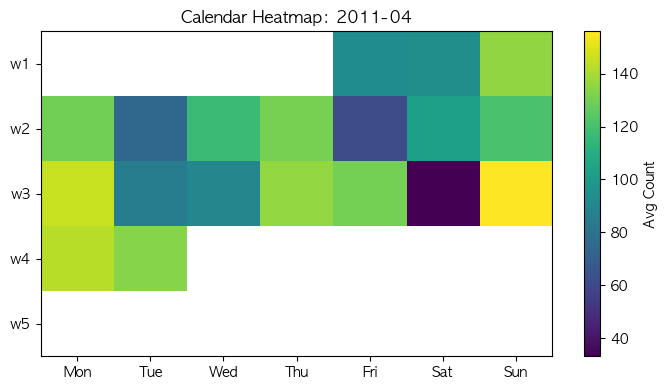

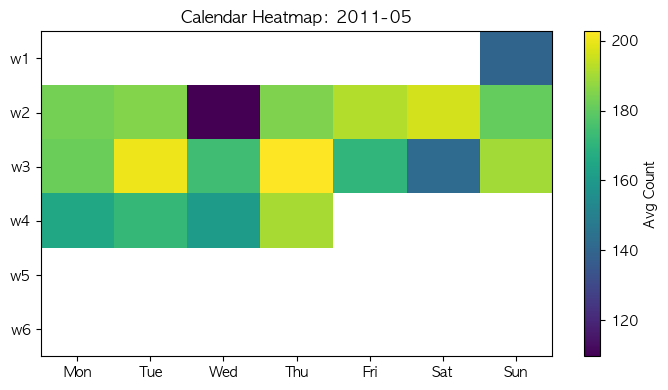

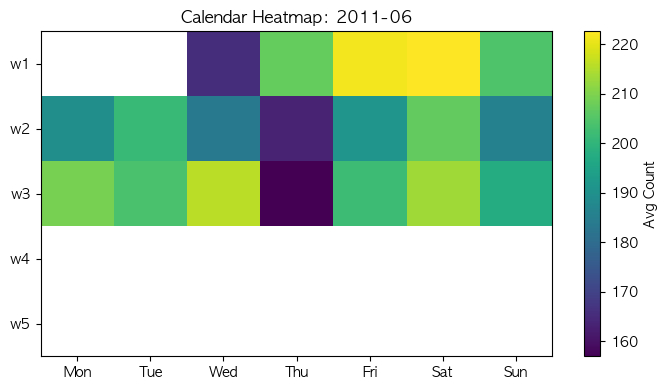

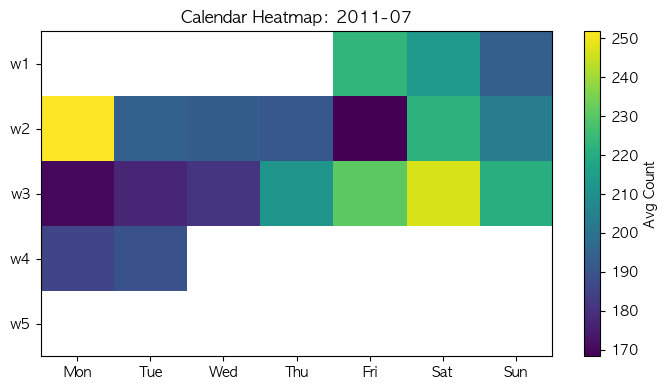

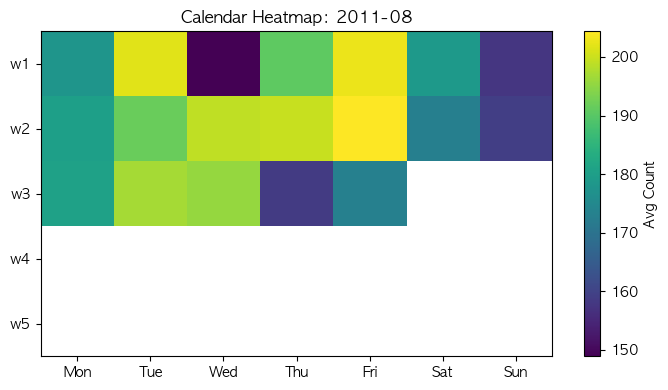

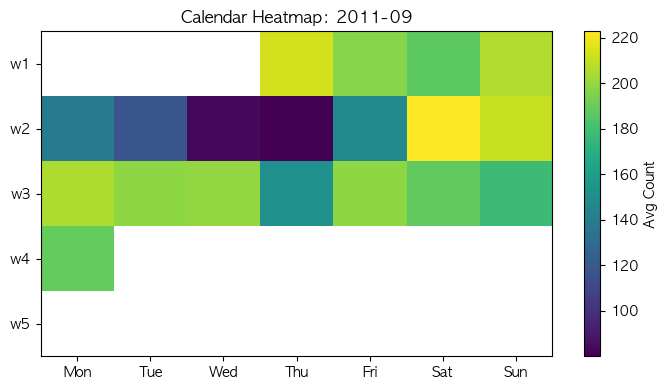

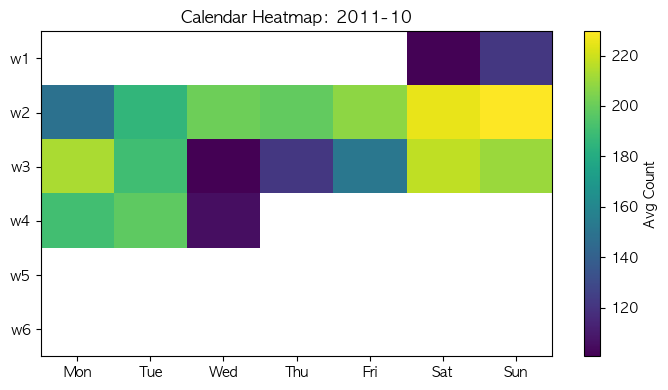

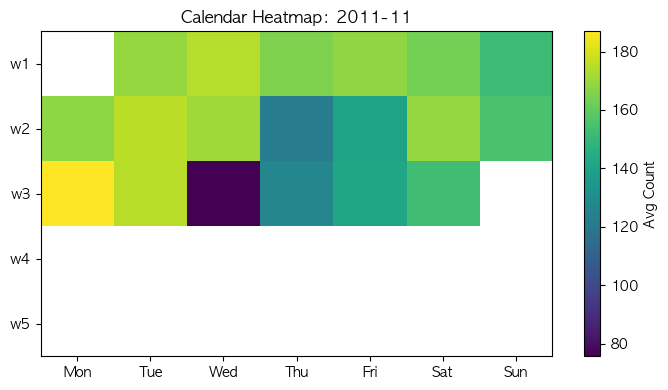

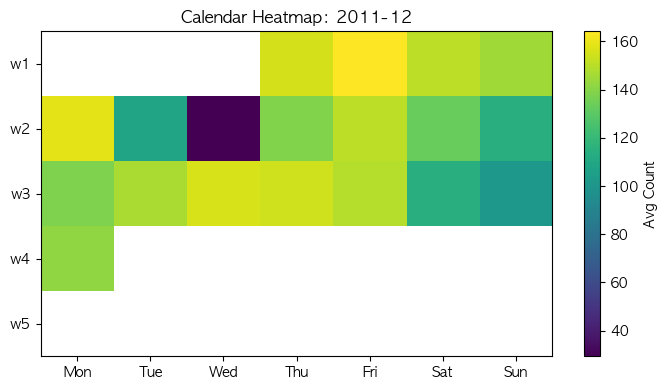

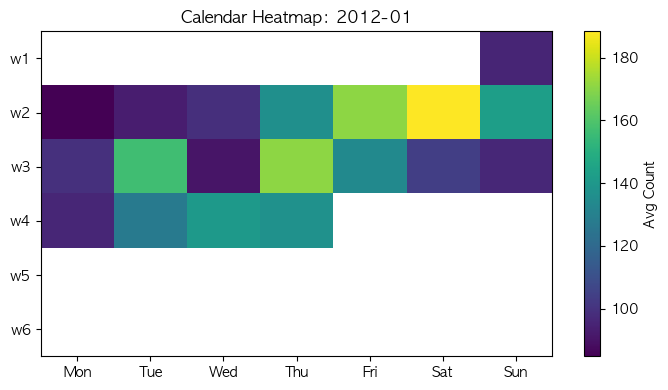

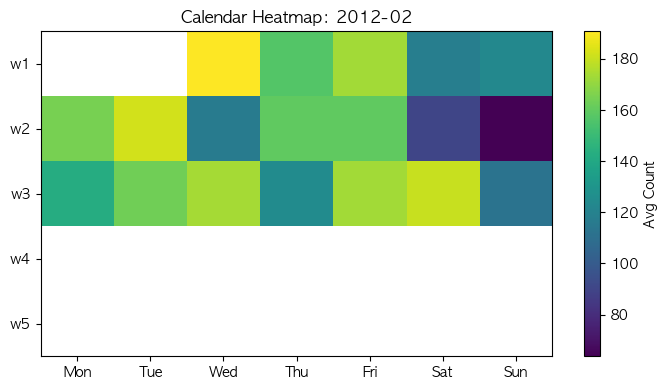

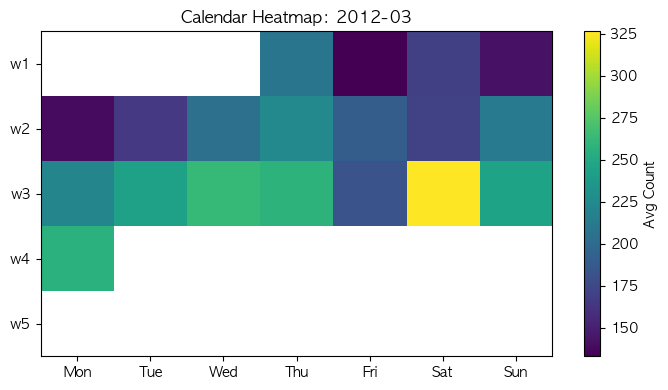

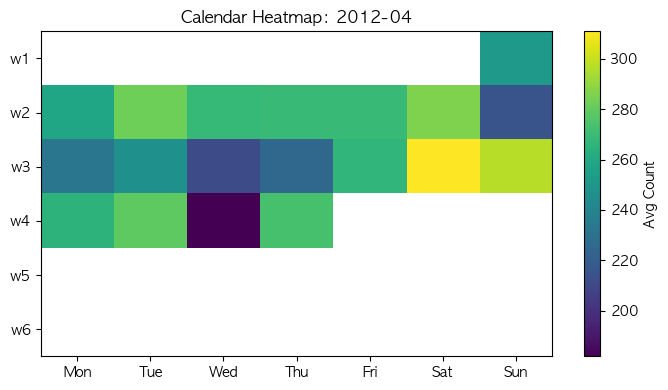

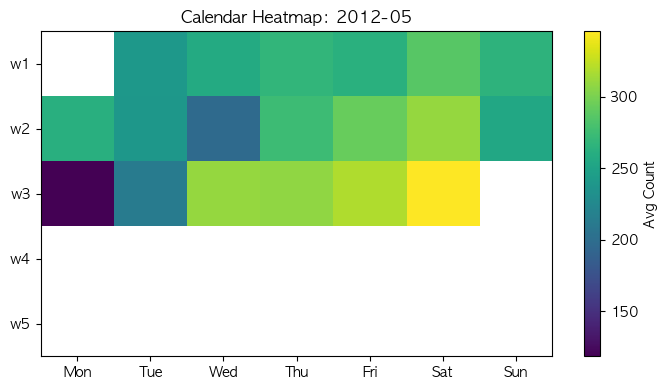

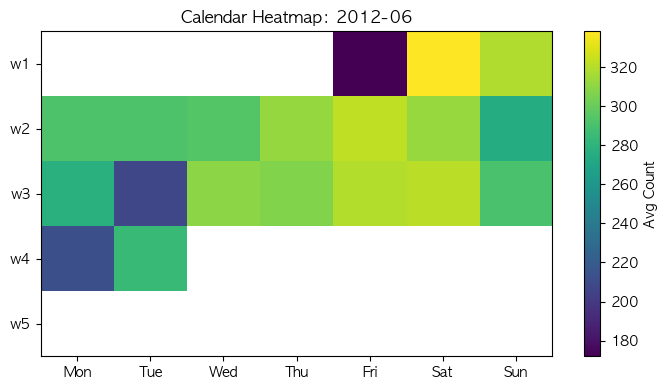

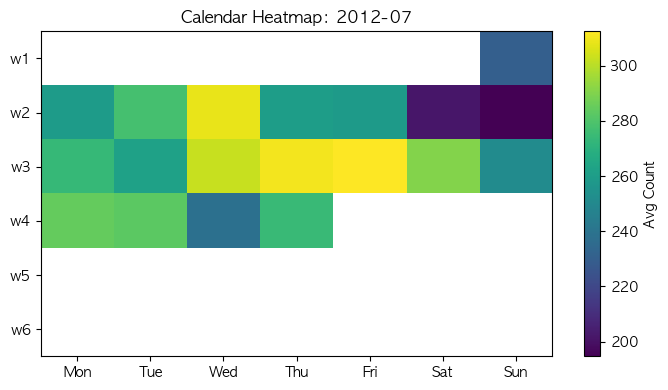

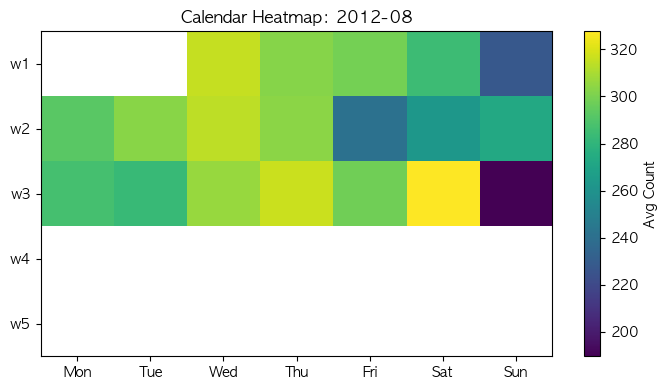

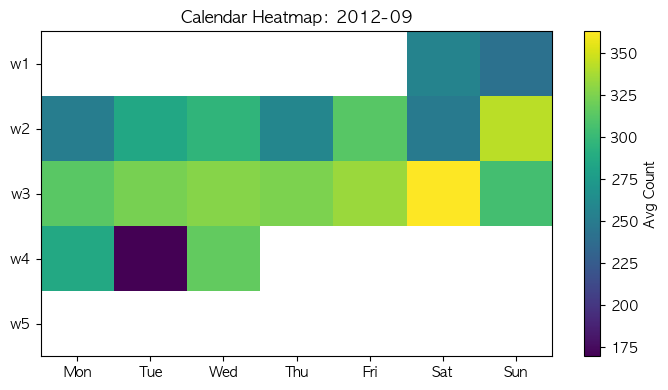

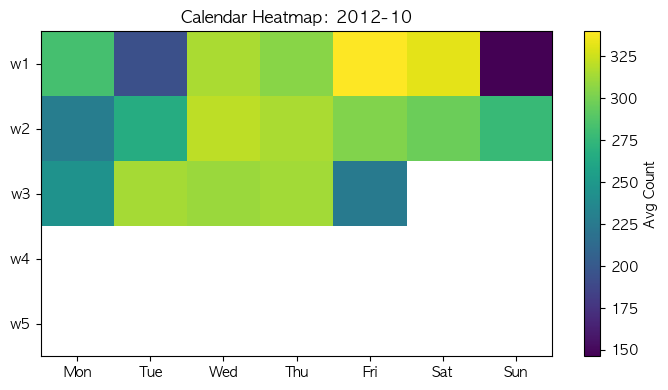

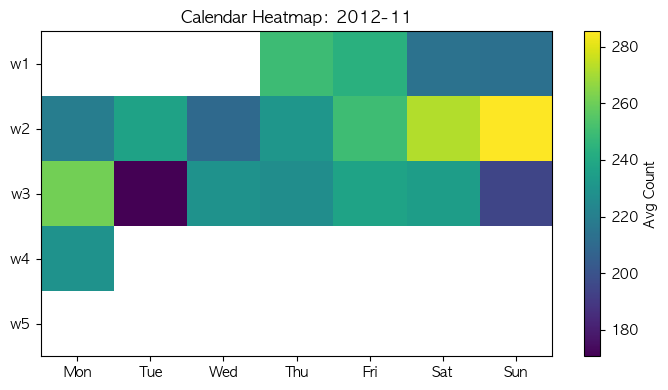

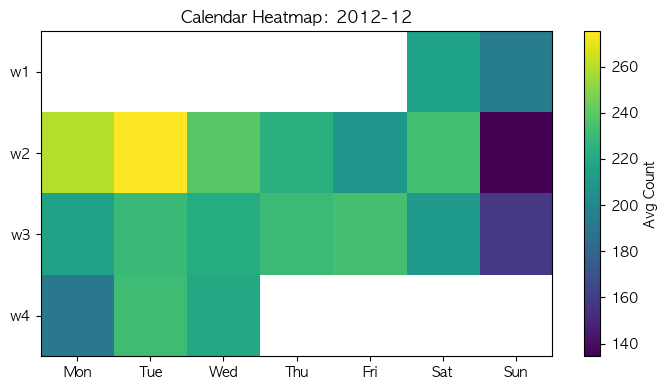

In [42]:
def calendar_heatmap_daily(daily_series: pd.Series) -> None:
    """
    월별 캘린더 히트맵: (week_of_month x weekday) 매트릭스로 일 평균 대여량 시각화
    - 월별 실제 최대 주차까지만 표시(w5/w6는 해당 월에 필요할 때만 표시)
    - 결측 셀(NaN)은 별도 색상(회색)으로 시각화하여 인지 가능하게 표시
    Args:
        daily_series: 일 단위 평균 시리즈 (DatetimeIndex, 빈도 불필요)
    """
    from matplotlib.patches import Patch

    s = daily_series.copy()
    dti = s.index
    year_month = dti.to_period('M')

    for ym, ss in s.groupby(year_month):
        if ss.empty:
            continue
        first = ss.index.min()
        # 월 내 각 날짜의 주차(0-base) 계산 후 최대 주차 결정
        week_idxs = [((d.day + first.weekday() - 1) // 7) for d in ss.index]
        max_weeks = max(week_idxs) + 1  # 표시할 실제 행 수
        cal = pd.DataFrame(index=range(max_weeks), columns=range(7), dtype=float)

        # 각 날짜를 (주차, 요일) 좌표에 배치
        for d, val in ss.items():
            week_of_month = ((d.day + first.weekday() - 1) // 7)
            cal.loc[week_of_month, d.weekday()] = val

        # # 결측값을 마스크하여 별도 색으로 표시
        data = np.ma.masked_invalid(cal.values)
        cmap = plt.cm.viridis.copy()
        # cmap.set_bad(color='lightgray', alpha=0.7)  # 결측: 회색

        plt.figure(figsize=(7,4))
        plt.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
        plt.title(f'Calendar Heatmap: {ym}')
        plt.yticks(range(max_weeks), [f'w{i + 1}' for i in range(max_weeks)])
        plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
        plt.colorbar(label='Avg Count')
        # 결측 범례 추가
        #missing_patch = Patch(facecolor='lightgray', edgecolor='none', label='결측')
        #plt.legend(handles=[missing_patch], loc='upper right', frameon=False)
        plt.tight_layout()
        plt.show()

calendar_heatmap_daily(daily)


#### 해설: 캘린더 히트맵
- 목적: 월별 요일×주차 패턴을 한 화면에서 확인.
- 해석:
  - 평일과 주말의 평균 강도 차이가 격자로 뚜렷이 구분됩니다.
  - 월초/월말의 비정상 구간은 결측/이벤트/기상 이슈 점검 포인트입니다.


### 5. 범주별 박스플롯(연/월/요일/시간)

- 연/월/요일/시간대에 따른 `count`의 분포를 비교해 이상값과 분산 차이를 직관적으로 파악합니다.
- `matplotlib`의 `boxplot`을 사용합니다(색상/스타일 지정 없이 기본값).


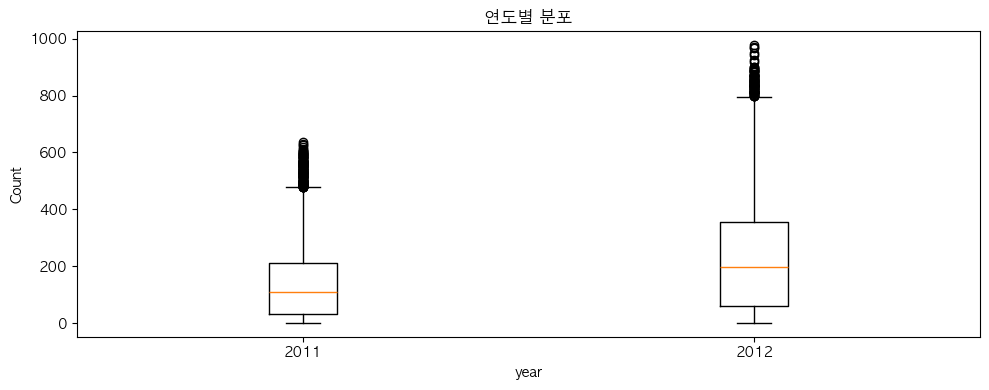

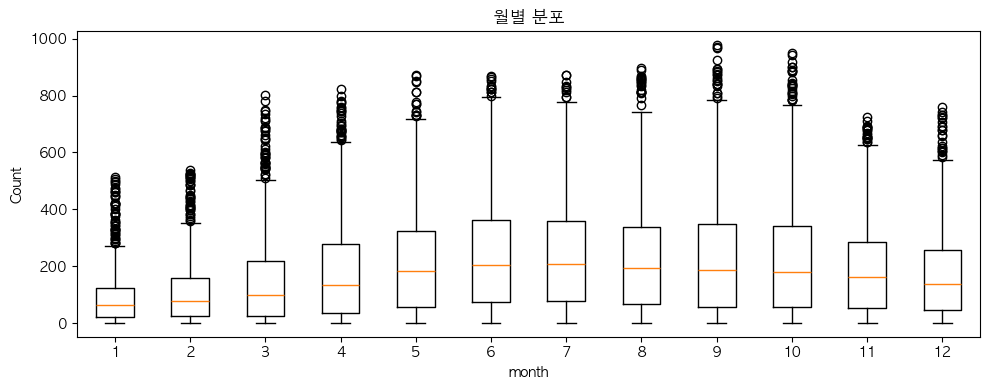

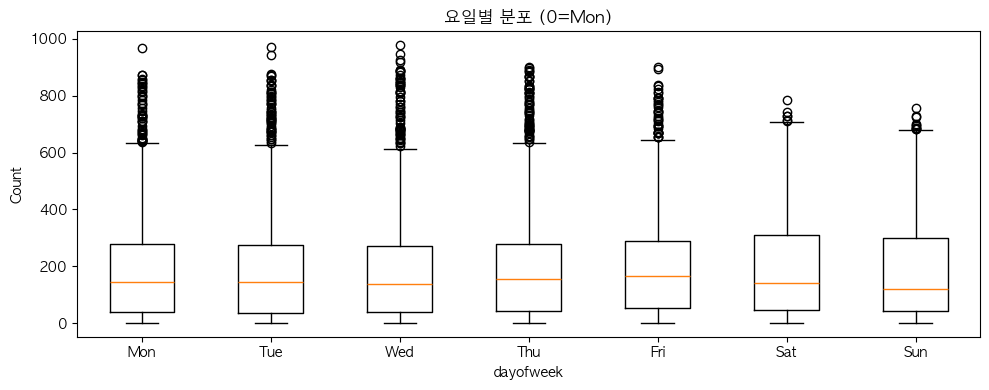

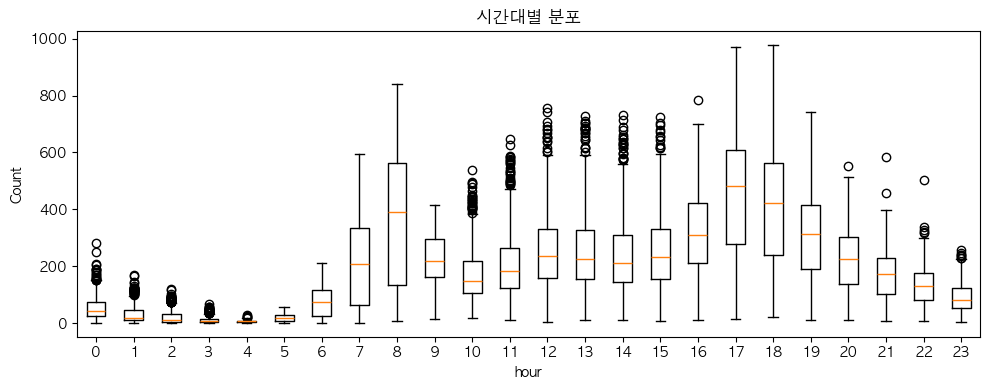

In [10]:
def boxplot_by_category(df_reset: pd.DataFrame, col: str, title: str, labels=None) -> None:
    plt.figure(figsize=(10,4))
    groups = [g['count'].values for _, g in df_reset.groupby(col)]
    plt.boxplot(groups, showfliers=True)
    if labels is None:
        labels = sorted(df_reset[col].unique())
    plt.xticks(range(1, len(groups)+1), labels, rotation=0)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 파생 범주 추가 및 박스플롯 실행
df_reset = _df.reset_index()
df_reset['year'] = df_reset['datetime'].dt.year
df_reset['month'] = df_reset['datetime'].dt.month
df_reset['dayofweek'] = df_reset['datetime'].dt.dayofweek
df_reset['hour'] = df_reset['datetime'].dt.hour

boxplot_by_category(df_reset, 'year', '연도별 분포')
boxplot_by_category(df_reset, 'month', '월별 분포', labels=list(range(1,13)))
boxplot_by_category(df_reset, 'dayofweek', '요일별 분포 (0=Mon)', labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
boxplot_by_category(df_reset, 'hour', '시간대별 분포', labels=list(range(24)))


#### 해설: 범주별 박스플롯
- 목적: 범주(연/월/요일/시간)별 분포(중앙값·사분위·이상치) 비교.
- 해석:
  - 연도: 분포가 연차에 따라 상향/하향하는지 확인해 구조적 변화 여부를 검토.
  - 월: 계절성(여름↑ 겨울↓)이 박스 높이로 드러납니다.
  - 요일: 근무일 중앙값이 주말 대비 높은 경향.
  - 시간: 출퇴근 피크와 심야 저점이 분명합니다.


### 6. 주중/주말 & 휴일 효과(평균±95% CI)

- 근무일(workingday), 주말(토·일), 공휴일(holiday) 조건에서 평균과 95% 신뢰구간을 막대로 비교합니다.
- 표본 표준오차로 근사한 CI를 사용합니다.


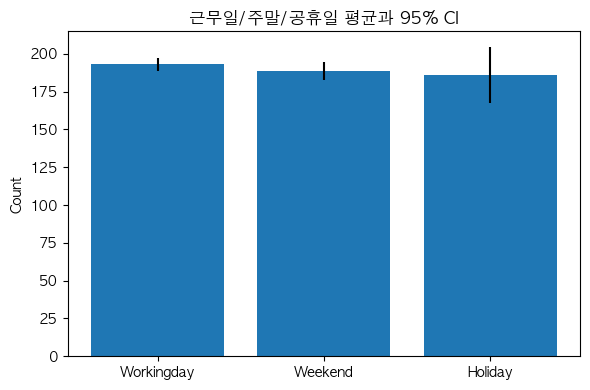

In [12]:
def mean_ci(vals: np.ndarray) -> tuple[float, float]:
    m = float(np.mean(vals))
    s = float(np.std(vals, ddof=1))
    n = len(vals)
    se = s / np.sqrt(max(n, 1))
    return m, 1.96 * se

profiles = []
for name, cond in {
    'Workingday': df_reset['workingday'] == 1,
    'Weekend': df_reset['dayofweek'] >= 5,
    'Holiday': df_reset['holiday'] == 1,
}.items():
    m, ci = mean_ci(df_reset.loc[cond, 'count'].values)
    profiles.append((name, m, ci))

plt.figure(figsize=(6,4))
x = np.arange(len(profiles))
means = [p[1] for p in profiles]
cis = [p[2] for p in profiles]
plt.bar(x, means, yerr=cis)
plt.xticks(x, [p[0] for p in profiles])
plt.title('근무일/주말/공휴일 평균과 95% CI')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#### 해설: 근무일/주말/공휴일 평균±CI
- 목적: 단순 집단 비교로 수요 레벨 차이를 검증.
- 해석:
  - 근무일 평균이 가장 높고 변동성도 일정.
  - 주말/공휴일에서 평균이 낮거나 CI가 넓어 수요 불확실성 증가가 관찰될 수 있습니다.


### 7. 날씨 변수와 수요의 비선형 관계(LOWESS)

- `temp`, `humidity`, `windspeed`와 `count`의 비선형 관계를 LOWESS로 부드럽게 시각화합니다.
- 점 산점도와 함께 LOWESS 곡선을 겹쳐 변동성과 경향을 동시에 확인합니다.


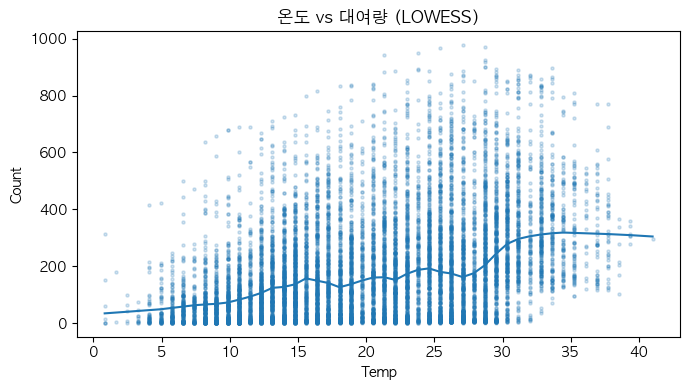

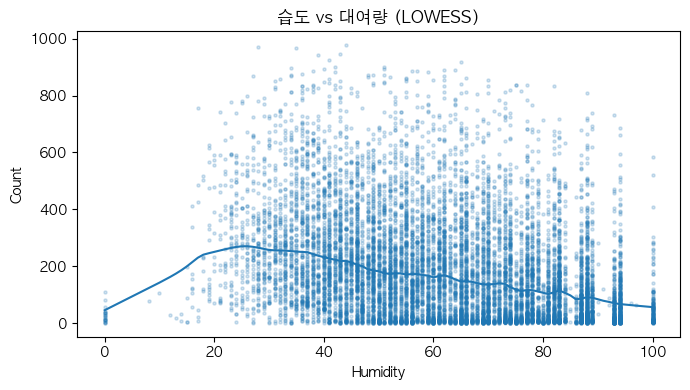

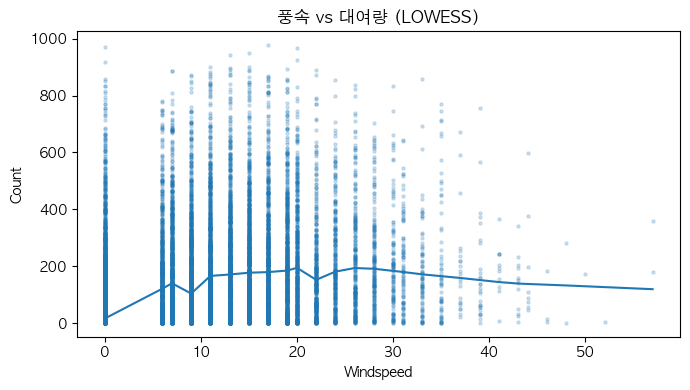

In [62]:
def scatter_lowess(x: np.ndarray, y: np.ndarray, xlabel: str, title: str) -> None:
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x_clean = x[mask]
    y_clean = y[mask]
    order = np.argsort(x_clean)
    xs, ys = x_clean[order], y_clean[order]
    sm = lowess(ys, xs, frac=0.1, return_sorted=True)
    plt.figure(figsize=(7,4))
    plt.scatter(xs, ys, s=5, alpha=0.2)
    plt.plot(sm[:,0], sm[:,1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

scatter_lowess(df_reset['temp'].values, df_reset['count'].values, 'Temp', '온도 vs 대여량 (LOWESS)')
scatter_lowess(df_reset['humidity'].values, df_reset['count'].values, 'Humidity', '습도 vs 대여량 (LOWESS)')
scatter_lowess(df_reset['windspeed'].values, df_reset['count'].values, 'Windspeed', '풍속 vs 대여량 (LOWESS)')


#### 해설: LOWESS(온도/습도/풍속)
- 목적: 비선형/비모수적 경향을 시각적으로 파악.
- 해석:
  - 온도: 저온/고온에서 수요 저하, 중간 온도대에서 수요 최대.
  - 습도: 고습 구간에서 체감 불쾌감으로 수요 하락 경향.
  - 풍속: 강풍 시 안전/피로 요인으로 수요 감소.


### 8. 이동평균/이동분산으로 비정상성 확인

- 창(window) 크기를 정해 이동평균/이동분산을 그려 평균/분산이 시간에 따라 변하는지 확인합니다.
- 일 단위로 집계한 `daily`에 대해 `window=7`을 예시로 사용합니다.


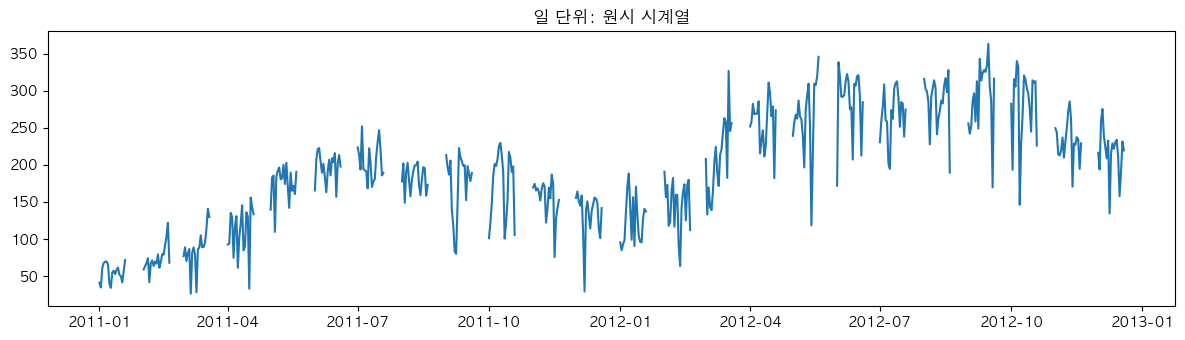

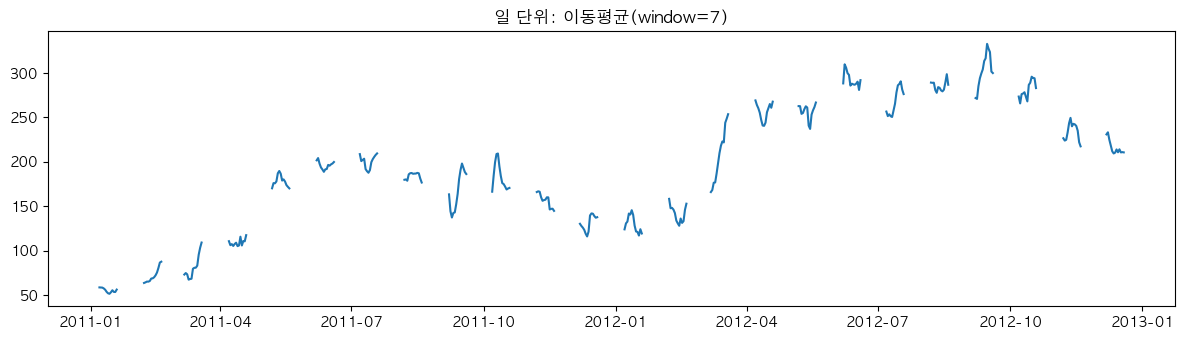

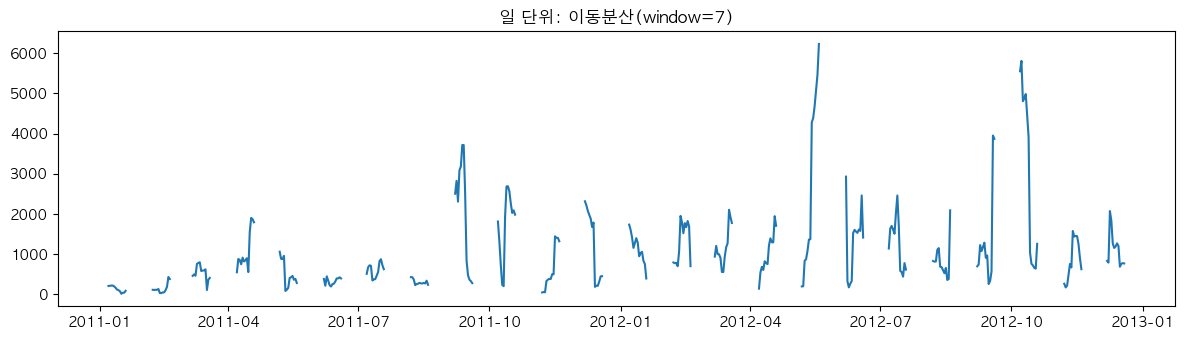

In [15]:
def rolling_stats(series: pd.Series, window: int, title_prefix: str) -> None:
    rm = series.rolling(window).mean()
    rv = series.rolling(window).var()

    plt.figure(figsize=(12,3.5))
    plt.plot(series.index, series.values)
    plt.title(f'{title_prefix}: 원시 시계열')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.5))
    plt.plot(rm.index, rm.values)
    plt.title(f'{title_prefix}: 이동평균(window={window})')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.5))
    plt.plot(rv.index, rv.values)
    plt.title(f'{title_prefix}: 이동분산(window={window})')
    plt.tight_layout()
    plt.show()

rolling_stats(daily, 7, '일 단위')


#### 해설: 이동평균/이동분산
- 목적: 평균/분산의 시간 변화로 비정상성 징후를 확인.
- 해석:
  - 이동평균: 수준 변화가 있으면 비정상(추세성) 시사.
  - 이동분산: 분산이 커졌다 작아지면 이분산성 가능성.
  - 차분/변환(log1p)로 안정화 시도를 고려합니다.


### 9. 분포와 변환(log1p)

- 원시 `daily` 분포와 `log1p` 변환 후 분포를 비교해 왜도/첨도 완화를 확인합니다.
- 예측/모델링에서 로그 변환은 분산 안정화와 비선형 완화에 도움을 줄 수 있습니다.


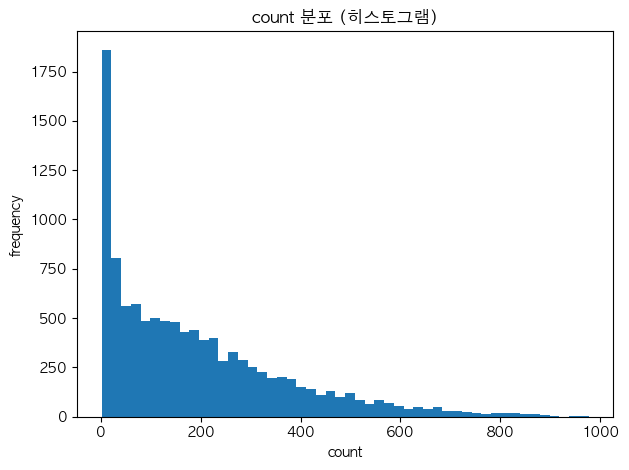

In [53]:

plt.figure()
plt.hist(df['count'], bins=50)
plt.title('count 분포 (히스토그램)')
plt.xlabel('count')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()


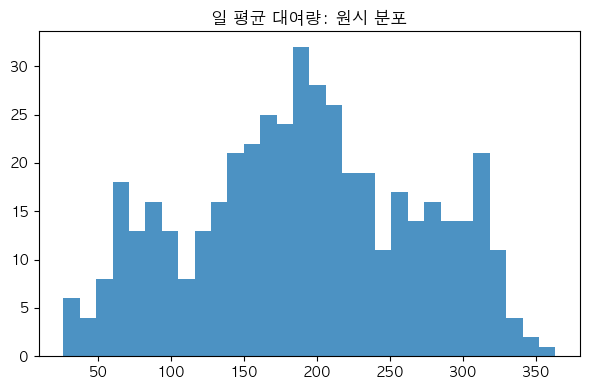

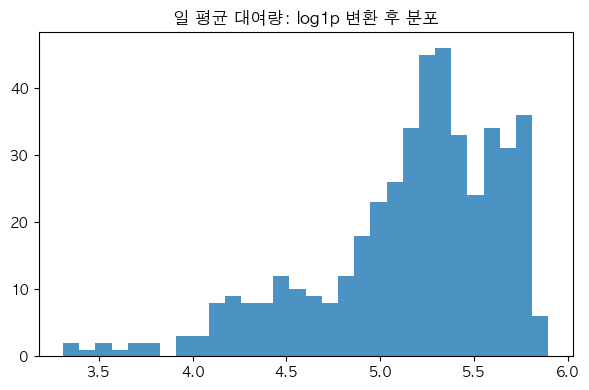

In [55]:
def hist_compare(raw: pd.Series, title_prefix: str) -> None:
    plt.figure(figsize=(6,4))
    plt.hist(raw.dropna(), bins=30, alpha=0.8)
    plt.title(f'{title_prefix}: 원시 분포')
    plt.tight_layout()
    plt.show()

    transformed = np.log1p(raw)
    plt.figure(figsize=(6,4))
    plt.hist(transformed.dropna(), bins=30, alpha=0.8)
    plt.title(f'{title_prefix}: log1p 변환 후 분포')
    plt.tight_layout()
    plt.show()

hist_compare(daily, '일 평균 대여량')


#### 해설: 분포와 log1p 변환
- 목적: 왜도/첨도 완화로 통계/모델 가정을 돕기 위함.
- 해석:
  - 원시 분포는 오른쪽 꼬리(극단적 고값)가 두드러짐.
  - log1p 변환 후 분포가 더 대칭적이 되어 회귀/ARIMA류 모델에 유리합니다.


### 10. 정상성 검정(ADF) — 원시/차분 비교

- ADF 검정으로 단위근(비정상성)을 가설검정합니다.
- 원시 시계열과 1차 차분/7일 차분(주간) 결과를 비교합니다.


In [17]:
def adf_test(series: pd.Series, name: str) -> None:
    s = series.dropna()
    res = adfuller(s, autolag='AIC')
    print(f'[ADF] {name}')
    print('  Test Statistic:', res[0])
    print('  p-value       :', res[1])
    print('  Lags Used     :', res[2])
    print('  N Observations:', res[3])
    print('  Critical Values:', res[4])
    print('-'*40)

adf_test(daily, 'Daily mean count')
adf_test(daily.diff(), 'Daily diff(1)')
adf_test(daily.diff(7), 'Daily diff(7) – 주간 차분')


[ADF] Daily mean count
  Test Statistic: -2.0059053240527365
  p-value       : 0.2839898382652216
  Lags Used     : 9
  N Observations: 446
  Critical Values: {'1%': np.float64(-3.4450973903602367), '5%': np.float64(-2.868042229965336), '10%': np.float64(-2.570233448893)}
----------------------------------------
[ADF] Daily diff(1)
  Test Statistic: -12.818499082794435
  p-value       : 6.225681302913506e-24
  Lags Used     : 5
  N Observations: 426
  Critical Values: {'1%': np.float64(-3.4457939940402107), '5%': np.float64(-2.8683485906158963), '10%': np.float64(-2.570396746236417)}
----------------------------------------
[ADF] Daily diff(7) – 주간 차분
  Test Statistic: -9.478102172488272
  p-value       : 3.939409985506681e-16
  Lags Used     : 2
  N Observations: 285
  Critical Values: {'1%': np.float64(-3.4535050041524245), '5%': np.float64(-2.8717352599720294), '10%': np.float64(-2.5722024776854417)}
----------------------------------------


#### 해설: ADF 정상성 검정
- 목적: 단위근 유무 확인(비정상성 판단).
- 해석:
  - 원시: p-value가 높으면 비정상.
  - 1차/7일 차분: p-value가 유의(작아짐)하면 정상성 개선.
  - 후속 모형에서 차분 차수 선택의 근거가 됩니다.


#### 해석 상세
#### 1. Daily mean count
- ADF 통계량: -2.006
- p-value: 0.284 (▶️ > 0.05)
- 해석: 귀무가설(단위근 존재 → 비정상 시계열)을 기각할 수 없음
- 이 시계열은 비정상입니다. 추세(trend) 또는 계절성(seasonality)이 존재할 가능성이 큽니다.
#### 2. Daily.diff(1) (1차 차분)
- ADF 통계량: -12.818
- p-value: 6.2e-24 (▶️ < 0.01)
- 해석: 귀무가설 기각 → 정상 시계열로 변환됨
- 1차 차분만으로도 정상성 확보 가능
#### 3. Daily.diff(7) (7일 차분, 주간 차분)
- ADF 통계량: -9.478
- p-value: 3.9e-16 (▶️ < 0.01)
- 해석: 역시 귀무가설 기각 → 정상성 확보
- 주간 단위로 차분해도 정상성이 확보됨
- 요일별 또는 주간 패턴이 존재함을 시사
#### 결론 및 실무적 시사점
- 원시 시계열은 비정상 → 모델링 전 차분 필요
- 1차 차분(diff(1))만으로도 충분히 정상화 가능
- 하지만 주간 차분(diff(7))도 좋은 대안
- 특히 요일 패턴, 주말/평일 수요 차이가 클 때 유용
- ARIMA 모델링 시 ARIMA(p,1,q) 또는 SARIMA(p,1,q,7) 같은 구조 고려 가능

### 11. 자기상관/부분자기상관(ACF/PACF)

- ACF/PACF로 시차별 상관구조를 확인합니다.
- 원시 `daily`와 1차 차분 시리즈를 비교해 모형(AR/MA) 힌트를 얻습니다.


<Figure size 800x400 with 0 Axes>

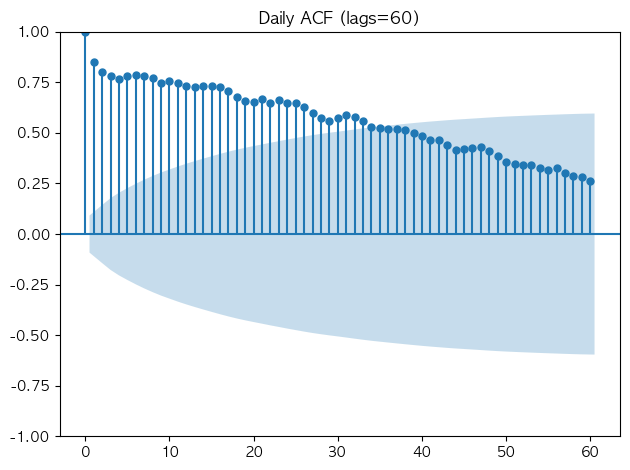

<Figure size 800x400 with 0 Axes>

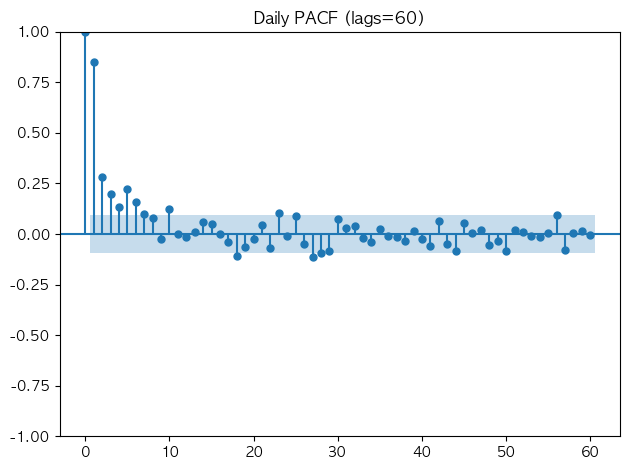

<Figure size 800x400 with 0 Axes>

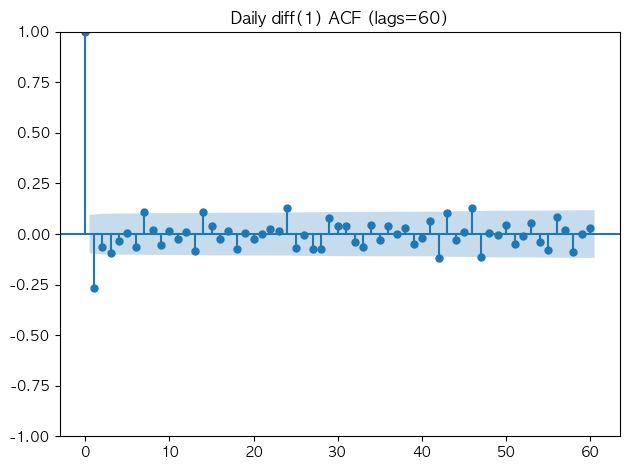

<Figure size 800x400 with 0 Axes>

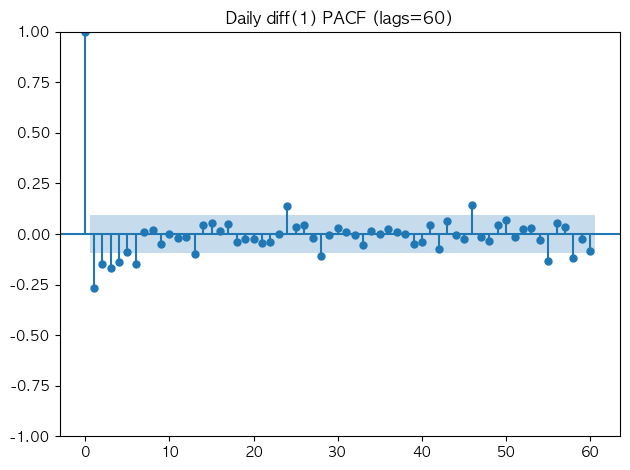

In [18]:
def acf_pacf(series: pd.Series, lags: int, title_prefix: str) -> None:
    s = series.dropna()
    plt.figure(figsize=(8,4))
    plot_acf(s, lags=lags)
    plt.title(f'{title_prefix} ACF (lags={lags})')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plot_pacf(s, lags=lags, method='ywm')
    plt.title(f'{title_prefix} PACF (lags={lags})')
    plt.tight_layout()
    plt.show()

acf_pacf(daily, 60, 'Daily')
acf_pacf(daily.diff(), 60, 'Daily diff(1)')


#### 해설: ACF/PACF
- 목적: 시차 구조 파악으로 AR/MA 차수 힌트 획득.
- 해석:
  - 원시: 장기 양의 자기상관(계절/추세) 가능성.
  - 1차 차분: 초기 래그에서 급감/절단형이면 MA/AR 단서를 제공합니다.


#### 해설: ACF/PACF
- 원시: 장기 양의 자기상관(계절/추세) 가능성.
- 1차 차분: 급감/절단형 패턴이 나타나면 MA/AR 단서 제공.


#### 해설: STL 분해
- Trend: 장기 방향성/전환점.
- Seasonal(7일): 일주기 평균 패턴.
- Residual: 이상치/미설명 변동.


### 12. STL 분해(추세/계절/잔차)

- `STL`로 일 단위 시계열을 `trend`, `seasonal`, `residual`로 분해해 각 성분을 개별 플롯으로 확인합니다.
- 일별 주기(period=7)를 사용합니다.


In [48]:
def stl_components(series: pd.Series, period: int, title_prefix: str):
    # 1) 인덱스 정리
    s = series.sort_index()
    if not isinstance(s.index, pd.DatetimeIndex):
        raise ValueError("series.index는 DatetimeIndex여야 합니다.")

    # 2) 데일리로 맞추고 결측 보간(필요시 resample 로직으로 교체 가능)
    s = s.asfreq('D')
    if s.isna().any():
        s = s.interpolate('time').ffill().bfill()

    # 3) STL 적합
    res = STL(s, period=period, robust=True).fit()

    # 4) 결과를 항상 pandas Series로
    comp = {
        'Trend':    pd.Series(res.trend,    index=s.index, name='Trend'),
        'Seasonal': pd.Series(res.seasonal, index=s.index, name='Seasonal'),
        'Residual': pd.Series(res.resid,    index=s.index, name='Residual'),
    }

    # 5) 플롯
    for k, v in comp.items():
        plt.figure(figsize=(12, 3.5))
        plt.plot(v.index, v.values)
        plt.title(f'{title_prefix} {k} (period={period})')
        plt.tight_layout()
        plt.show()

    # 6) 딕셔너리 대신 DataFrame으로도 반환 가능
    # return pd.DataFrame(comp)
    return comp


#### 해설: STL 분해(period=7)
- 목적: 추세/계절/잔차 성분을 분리해 해석 가능성 향상.
- 해석:
  - Trend: 장기 상승/하강 전환점 파악.
  - Seasonal: 주간(7일) 반복 패턴의 강도와 변동 확인.
  - Residual: 이상치/모형 미설명 변동 탐색.


#### 1. 추세(Trend)
 - 2011년 초부터 2012년 가을까지 전반적으로 완만하게 상승
 - 2011년 봄에서 여름까지는 완만하게 상승
 - 2011년 9월부터 11월 사이에는 뚜렷한 하락
 - 2012년 봄에서 여름에는 큰 폭의 상승
 - 2012년 가을 이후에는 다소 하락세
 - 장기적인 성장세 속에서 계절 요인이나 외부 요인에 따른 단기 하락 구간 존재
#### 2. 계절성(Seasonal)
 - 주기 설정 값이 7이어서 주간 패턴이 뚜렷하게 나타남
 - 매주 특정 요일에 수치가 상승하거나 하락하는 현상이 반복
 - 최고점과 최저점 사이의 차이가 일정하지 않음
 - 2011년 9월에서 10월, 2012년 1월에서 2월에 변동 폭이 커짐
 - 주중과 주말의 차이, 특정 요일의 반복 패턴이 존재하며 특정 시기에 계절성이 강화됨
#### 3. 잔차(Residual)
 - 대부분 0 근처에 분포
 - 2011년 9월에서 10월, 2012년 1월에서 2월, 2012년 7월에서 8월에 큰 변동 발생
 - 추세와 계절성으로 설명되지 않는 돌발 요인이 존재
 - 돌발 요인의 예로는 특수 이벤트, 공급 문제, 날씨 변화, 마케팅 캠페인, 외부 충격 등이 있음
#### 4. 종합 해석
 - 전반적으로 완만한 상승 추세
 - 주간 반복 패턴이 강하게 나타남
 - 일부 시기에 계절성의 변동 폭이 커지고 잔차 변동성도 확대됨
 - 분석 결과는 재고와 인력 배치 최적화, 마케팅 및 프로모션 시점 조정, 이상치 탐지 및 원인 분석에 활용 가능

### 14. 시즌별 시간대 프로파일

- `season` 값별로 시간대(`hour`) 평균 수요 프로파일을 비교합니다.
- 출퇴근/계절 영향 등 시간적 패턴 차이를 확인합니다.


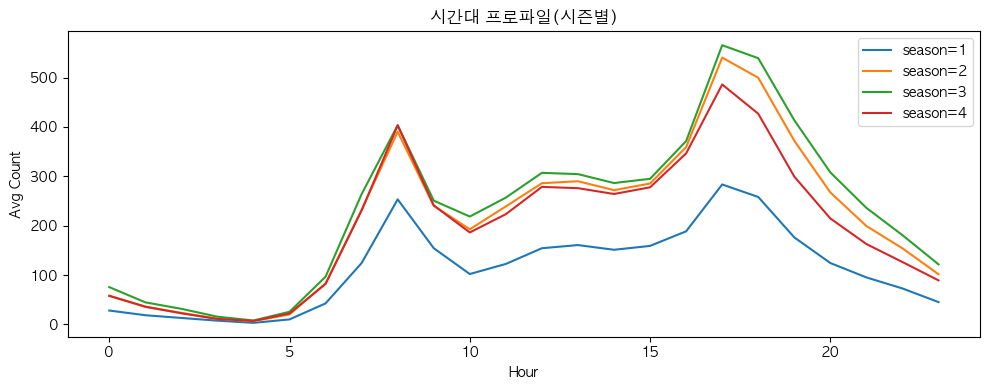

In [21]:
def hourly_profile_by_season(df_reset: pd.DataFrame) -> None:
    fig_data = {}
    for s in sorted(df_reset['season'].unique()):
        sub = df_reset[df_reset['season'] == s]
        prof = sub.groupby('hour')['count'].mean()
        fig_data[s] = prof

    plt.figure(figsize=(10,4))
    for s, prof in fig_data.items():
        plt.plot(prof.index, prof.values, label=f'season={s}')
    plt.title('시간대 프로파일(시즌별)')
    plt.xlabel('Hour')
    plt.ylabel('Avg Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

hourly_profile_by_season(df_reset)


#### 해설: 시즌별 시간대 프로파일
- 여름: 저녁 피크 강화(야외활동 증가), 겨울: 전반적 레벨 하락.
- 출퇴근 피크(아침/저녁)는 모든 시즌에 공통적으로 나타납니다.


#### 해설: 시즌별 시간대 프로파일
- 목적: 시즌에 따른 시간대 패턴 차이를 가시화.
- 해석:
  - 여름: 저녁 피크 강화(야외활동 증가).
  - 겨울: 전반적 레벨 하락과 피크 완화.
  - 공통: 출퇴근 피크(아침/저녁)는 대부분 시즌에서 유지.


### 16. 이상치(Outlier) 탐색 — IQR 기반

- IQR 범위를 벗어나는 상·하위 구간을 표시해 비정상 구간을 탐색합니다.
- 해석 시 맥락(날씨/이벤트/점검기간 등)을 고려해 실질적 이상인지 판단합니다.


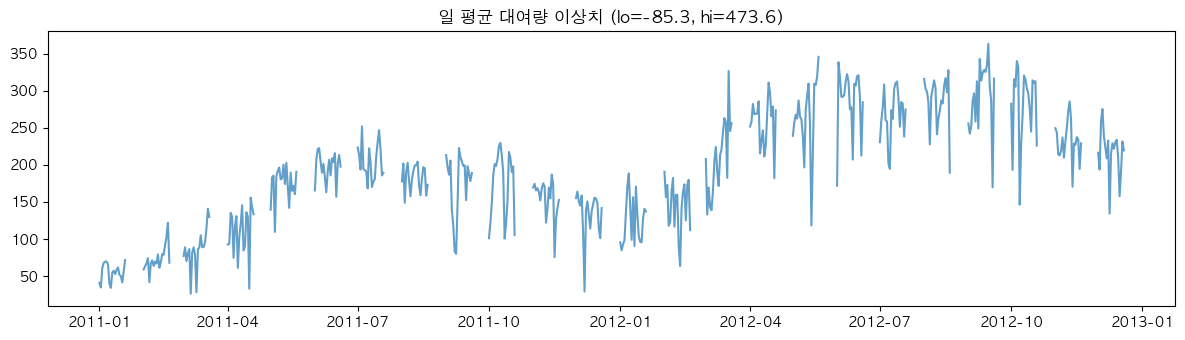

이상치 개수: 0


In [23]:
def outlier_mark(series: pd.Series, k: float = 1.5, title: str = 'IQR 기반 이상치') -> None:
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = (series < lo) | (series > hi)
    plt.figure(figsize=(12,3.5))
    plt.plot(series.index, series.values, alpha=0.7)
    plt.scatter(series.index[mask], series.values[mask], s=10)
    plt.title(f'{title} (lo={lo:.1f}, hi={hi:.1f})')
    plt.tight_layout()
    plt.show()
    print("이상치 개수:", int(mask.sum()))

outlier_mark(daily, k=2.0, title='일 평균 대여량 이상치')


#### 해설: IQR 이상치 탐색
- 목적: 규칙적 패턴에서 벗어난 관측치 식별.
- 해석:
  - 상단 이상치: 이벤트/날씨 호조건/데이터 중복 가능.
  - 하단 이상치: 악천후/시스템 장애/데이터 유실 가능.
  - 이상치는 제거보다 ‘원인 규명 후 처리’가 바람직합니다.


#### 요약 해설: IQR 이상치
- IQR 범위를 벗어난 관측치를 점으로 표시했습니다. 상단은 과도 수요(이벤트/기상), 하단은 악천후/장애 가능성을 시사합니다.


### 17. 결측 보간 시연(FFill/Linear)

- 결측이 없더라도 실습을 위해 일부를 의도적으로 `NaN`으로 만든 후, `ffill`과 `linear` 보간을 비교합니다.
- 실제 업무에서는 결측 원인/길이/주기 성격 등을 고려해 적절한 방법을 선택해야 합니다.


#### 요약 해설: 결측 보간 결과
- ffill: 직전 수준을 유지해 급격한 변동을 완화하지만, 긴 구간에서는 계단형 왜곡이 커질 수 있습니다.
- linear: 양 끝점을 직선으로 연결해 추세를 보존합니다. 길고 완만한 결측에 유리합니다.


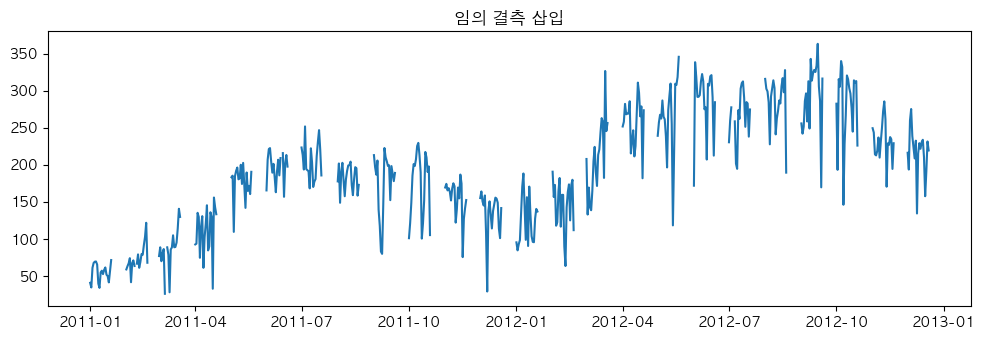

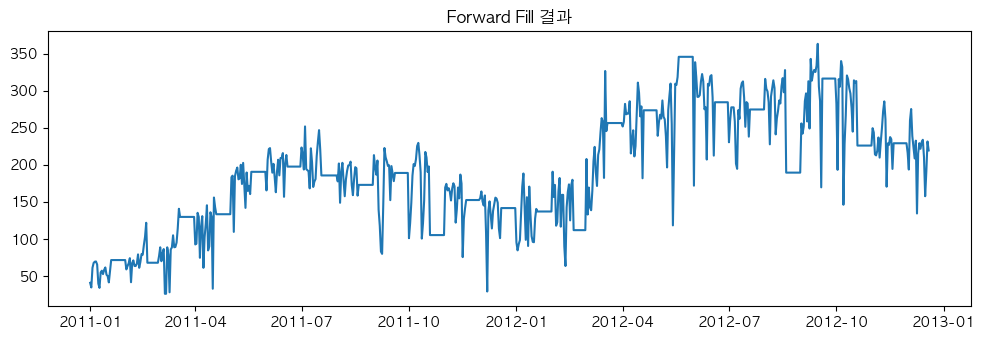

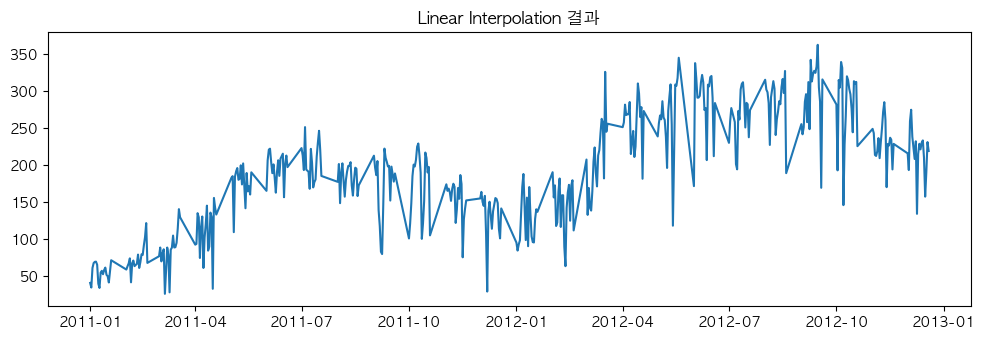

In [24]:
def imputation_demo(series: pd.Series) -> None:
    s = series.copy()
    # 임의 결측 삽입(1%)
    idx = s.sample(frac=0.01, random_state=42).index
    s.loc[idx] = np.nan

    plt.figure(figsize=(10,3.5))
    plt.plot(s.index, s.values)
    plt.title('임의 결측 삽입')
    plt.tight_layout()
    plt.show()

    ffill = s.ffill()
    plt.figure(figsize=(10,3.5))
    plt.plot(ffill.index, ffill.values)
    plt.title('Forward Fill 결과')
    plt.tight_layout()
    plt.show()

    lin = s.interpolate(method='linear')
    plt.figure(figsize=(10,3.5))
    plt.plot(lin.index, lin.values)
    plt.title('Linear Interpolation 결과')
    plt.tight_layout()
    plt.show()

imputation_demo(daily)


#### 해설: 결측 보간 시연
- 목적: 결측 처리 방법의 효과 비교.
- 해석:
  - Forward-fill: 단계형으로 직전 수준 유지. 짧은 결측에 유리.
  - Linear: 선형 추세를 보존. 긴 결측/완만한 추세 구간에 유리.
  - 주기성 데이터를 보간할 때는 seasonality-aware 방법도 고려하세요.
